<a href="https://colab.research.google.com/github/vicente-gonzalez-ruiz/learned_image_compression/blob/main/notebooks/RateDistortionOptimizedAutoencoder_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rate/Distortion Optimized Autoencoder
Based on [Learned data compression](https://www.tensorflow.org/tutorials/generative/data_compression).

In [1]:
# We minimize: J = R + LAMBDA*D
# Notice that, if LAMBDA is high, we basically minimize D at the expense of increasing R as much as necessary), and viceversa.

In [2]:
%%bash
# Installs the latest version of TFC compatible with the installed TF version.

read MAJOR MINOR <<< "$(pip show tensorflow | perl -p -0777 -e 's/.*Version: (\d+)\.(\d+).*/\1 \2/sg')"
pip install "tensorflow-compression<$MAJOR.$(($MINOR+1))"

In [3]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_compression as tfc
import tensorflow_datasets as tfds
from keras.callbacks import Callback
import numpy as np
import keras
import os
from IPython.display import display, clear_output

In [4]:
training_dataset, validation_dataset = tfds.load(
    "cifar10",
    split=["train[:80%]", "train[80%:]"],
    shuffle_files=True,
    as_supervised=True,
    with_info=False,
)
print(len(training_dataset), len(validation_dataset))

40000 10000


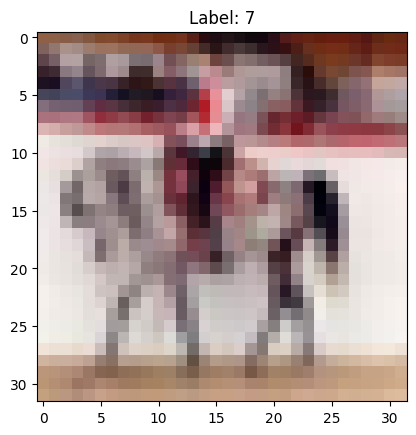

In [5]:
for image, label in training_dataset.take(1):
    # Display the image
    plt.imshow(image)
    plt.title(f"Label: {label.numpy()}")
    plt.show()

In [6]:
PRE_LATENT_SIZE = 2000
LATENT_SIZE = 100
EPOCHS = 100
LAMBDA = 500 #10000

# Original proposal.
#
# Analysis Transform architecture:
#
#            Ouput
#  Number  Feature
#      of      Map
# Neurons    Shape   Name Info
# ======= ======== ====== =============...
#       0  32*32*3      - Input: (height * width * depth)
#      20 16*16*20 conv_1 Conv2D(filters=20, kernel_size=5, strides=(2, 2), padding="yes"), 3 input channels of size 32*32, 5*5*3*20 + 20 = 1520 parameters
#      50   8*8*50 conv_2 Conv2D(filters=50, kernel_size=5, strides=(2, 2), padding="yes"), 20 input channels of size 16*16, 5*5*20*50 + 50 = 25050 parameters
#    2000     2000   fc_1 Dense(units=2000), 8*8*50*2000 + 2000 = 3200*2000 + 2000 = 6402000 parameters
#     100      100   fc_2 Dense(units=100), 2000*100 + 100 = 200100 parameters

def make_analysis_transform(latent_dims=LATENT_SIZE):
  """Creates the analysis (encoder) transform."""
  encoder = tf.keras.Sequential([
      tf.keras.layers.Conv2D(
          20, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2D(
          50, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(
          PRE_LATENT_SIZE, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          latent_dims, use_bias=True, activation=None, name="fc_2"),
  ], name="analysis_transform")
  return encoder

# Synthesis Transform architecture:
#
#           Output
#  Number  Feature
#      of      Map
# Neurons    Shape   Name Info
# ======= ======== ====== =============...
#       0      100      - Input: (100)
#    2000     2000   fc_1 Dense(units=2000), 100*2000 + 2000 = 202000 parameters
#    3200     3200   fc_2 Dense(units=3200), 2000*3200 + 3200 = 6403200 parameters, 8*8*50 = 3200
#      20 16*16*20 conv_1 Conv2DTranspose(filters=20, kernel_size=5, strides=(2, 2), padding="yes"), 50 input channels of size 8*8, 5*5*50*20 + 20 = 25020 parameters
#       3  32*32*3 conv_2 Conv2DTranspose(filters=3, kernel_size=5, strides=(2, 2), padding="yes"), 20 input channels of size 16*16, 5*5*20*3 + 3 = 1503 parameters

def make_synthesis_transform():
  """Creates the synthesis (decoder) transform."""
  decoder = tf.keras.Sequential([
      tf.keras.layers.Dense(
          PRE_LATENT_SIZE, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          3200, use_bias=True, activation="leaky_relu", name="fc_2"),
      tf.keras.layers.Reshape((8, 8, 50)),
      tf.keras.layers.Conv2DTranspose(
          20, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2DTranspose(
          3, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
  ], name="synthesis_transform")
  return decoder

# R=0.31640625 D=19.109853744506836, epoch 10, LAMBDA=500

In [7]:
PRE_LATENT_SIZE = 2000
LATENT_SIZE = 100
EPOCHS = 10

# Same architecture, but using strides=1.
#
# Analysis Transform architecture:
#
#            Ouput
#  Number  Feature
#      of      Map
# Neurons    Shape   Name Info
# ======= ======== ====== =============...
#       0  32*32*3      - Input: (height * width * depth)
#      20 32*32*20 conv_1 Conv2D(filters=20, kernel_size=5, strides=(1, 1), padding="yes"), 3 input channels of size 32*32, 5*5*3*20 + 20 = 1520 parameters
#      50 32*32*50 conv_2 Conv2D(filters=50, kernel_size=5, strides=(1, 1), padding="yes"), 20 input channels of size 32*32, 5*5*20*50 + 50 = 25050 parameters
#    2000     2000   fc_1 Dense(units=2000), 32*32*50*2000 + 2000 = 51200*2000 + 2000 = 102402000 parameters
#     100      100   fc_2 Dense(units=100), 2000*100 + 100 = 200100 parameters

def make_analysis_transform(latent_dims=LATENT_SIZE):
  """Creates the analysis (encoder) transform."""
  encoder = tf.keras.Sequential([
      tf.keras.layers.Conv2D(
          20, 5, use_bias=True, strides=1, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2D(
          50, 5, use_bias=True, strides=1, padding="same",
          activation="leaky_relu", name="conv_2"),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(
          PRE_LATENT_SIZE, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          latent_dims, use_bias=True, activation=None, name="fc_2"),
  ], name="analysis_transform")
  return encoder

# Synthesis Transform architecture:
#
#           Output
#  Number  Feature
#      of      Map
# Neurons    Shape   Name Info
# ======= ======== ====== =============...
#       0      100      - Input: (100)
#    2000     2000   fc_1 Dense(units=2000), 100*2000 + 2000 = 202000 parameters
#    3200     3200   fc_2 Dense(units=3200), 2000*51200 + 51200 = 102451200 parameters, 32*32*50 = 51200
#      20 32*32*20 conv_1 Conv2DTranspose(filters=20, kernel_size=5, strides=(1, 1), padding="yes"), 50 input channels of size 32*32, 5*5*50*20 + 20 = 25020 parameters
#       3  32*32*3 conv_2 Conv2DTranspose(filters=3, kernel_size=5, strides=(1, 1), padding="yes"), 20 input channels of size 32*32, 5*5*20*3 + 3 = 1503 parameters

def make_synthesis_transform():
  """Creates the synthesis (decoder) transform."""
  decoder = tf.keras.Sequential([
      tf.keras.layers.Dense(
          PRE_LATENT_SIZE, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          51200, use_bias=True, activation="leaky_relu", name="fc_2"),
      tf.keras.layers.Reshape((32, 32, 50)),
      tf.keras.layers.Conv2DTranspose(
          20, 5, use_bias=True, strides=1, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2DTranspose(
          3, 5, use_bias=True, strides=1, padding="same",
          activation="leaky_relu", name="conv_2"),
  ], name="synthesis_transform")
  return decoder

# R=0.3193359375 D=18.908967971801758, epoch 6, LAMBDA=500

In [8]:
EPOCHS = 100
LAMBDA = 500 #10000
LATENT_SIZE = 8*8*50

# Using only convolutional layers, strides=2.
#
# Analysis Transform architecture:
#
#            Ouput
#  Number  Feature
#      of      Map
# Neurons    Shape   Name Info
# ======= ======== ====== =============...
#       0  32*32*3      - Input: (height * width * depth)
#      20 16*16*20 conv_1 Conv2D(filters=20, kernel_size=5, strides=(2, 2), padding="yes"), 3 input channels of size 32*32, 5*5*3*20 + 20 = 1520 parameters
#      50   8*8*50 conv_2 Conv2D(filters=50, kernel_size=5, strides=(2, 2), padding="yes"), 20 input channels of size 16*16, 5*5*20*50 + 50 = 25050 parameters

def make_analysis_transform(latent_dims):
  """Creates the analysis (encoder) transform."""
  encoder = tf.keras.Sequential([
      tf.keras.layers.Conv2D(
          20, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2D(
          50, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
      tf.keras.layers.Flatten(),
  ], name="analysis_transform")
  return encoder

# Synthesis Transform architecture:
#
#           Output
#  Number  Feature
#      of      Map
# Neurons    Shape   Name Info
# ======= ======== ====== =============...
#       0   8*8*50      - Input: (3200)
#      20 16*16*20 conv_1 Conv2DTranspose(filters=20, kernel_size=5, strides=(2, 2), padding="yes"), 50 input channels of size 8*8, 5*5*50*20 + 20 = 25020 parameters
#       3  32*32*3 conv_2 Conv2DTranspose(filters=3, kernel_size=5, strides=(2, 2), padding="yes"), 20 input channels of size 16*16, 5*5*20*3 + 3 = 1503 parameters

def make_synthesis_transform():
  """Creates the synthesis (decoder) transform."""
  decoder = tf.keras.Sequential([
      tf.keras.layers.Reshape((8, 8, 50)),
      tf.keras.layers.Conv2DTranspose(
          20, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2DTranspose(
          3, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
  ], name="synthesis_transform")
  return decoder

# R=9.2236328125 D=6.935627460479736, epoch 25, LAMBDA=500

In [9]:
EPOCHS = 100
LAMBDA = 500 #10000
LATENT_SIZE = 32*32*50

# Using only convolutional layers, strides=1.
#
# Analysis Transform architecture:
#
#            Ouput
#  Number  Feature
#      of      Map
# Neurons    Shape   Name Info
# ======= ======== ====== =============...
#       0  32*32*3      - Input: (height * width * depth)
#      20 32*32*20 conv_1 Conv2D(filters=20, kernel_size=5, strides=(1, 1), padding="yes"), 3 input channels of size 32*32, 5*5*3*20 + 20 = 1520 parameters
#      50 32*32*50 conv_2 Conv2D(filters=50, kernel_size=5, strides=(1, 1), padding="yes"), 20 input channels of size 32*32, 5*5*20*50 + 50 = 25050 parameters

def make_analysis_transform(latent_dims=100):
  """Creates the analysis (encoder) transform."""
  encoder = tf.keras.Sequential([
      tf.keras.layers.Conv2D(
          20, 5, use_bias=True, strides=1, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2D(
          50, 5, use_bias=True, strides=1, padding="same",
          activation="leaky_relu", name="conv_2"),
      tf.keras.layers.Flatten(),
  ], name="analysis_transform")
  return encoder

# Synthesis Transform architecture:
#
#           Output
#  Number  Feature
#      of      Map
# Neurons    Shape   Name Info
# ======= ======== ====== =============...
#       0 32*32*50      - Input: (3200)
#      20 32*32*20 conv_1 Conv2DTranspose(filters=20, kernel_size=5, strides=(2, 2), padding="yes"), 50 input channels of size 8*8, 5*5*50*20 + 20 = 25020 parameters
#       3  32*32*3 conv_2 Conv2DTranspose(filters=3, kernel_size=5, strides=(2, 2), padding="yes"), 20 input channels of size 16*16, 5*5*20*3 + 3 = 1503 parameters

def make_synthesis_transform():
  """Creates the synthesis (decoder) transform."""
  decoder = tf.keras.Sequential([
      tf.keras.layers.Reshape((32, 32, 50)),
      tf.keras.layers.Conv2DTranspose(
          20, 5, use_bias=True, strides=1, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2DTranspose(
          3, 5, use_bias=True, strides=1, padding="same",
          activation="leaky_relu", name="conv_2"),
  ], name="synthesis_transform")
  return decoder

# R=141.14453125 D=5.647729873657227, epoch 10, LAMBDA=500

In [10]:
'''EPOCHS = 100
LAMBDA = 500 #10000
PRE_LATENT_SIZE = 4096
LATENT_SIZE = 256

# Original proposal.
#
# Analysis Transform architecture:
#
#             Ouput
#  Number   Feature
#      of       Map
# Neurons     Shape   Name Info
# ======= ========= ====== =============...
#       0   32*32*3      - Input: (height * width * depth)
#     256 16*16*256 conv_1 Conv2D(filters=256, kernel_size=5, strides=(2, 2), padding="yes"), 3 input channels of size 32*32, 5*5*3*256 + 256 = 19456 parameters
#     256   8*8*256 conv_2 Conv2D(filters=256, kernel_size=5, strides=(2, 2), padding="yes"), 256 input channels of size 16*16, 5*5*256*256 + 256 = 1638656 parameters
#    4096      4096   fc_1 Dense(units=4096), 8*8*256*4096 + 4096 = 16384*4096 + 4096 = 67112960 parameters
#     256       256   fc_2 Dense(units=256), 4096*256 + 256 = 1048832 parameters

def make_analysis_transform(latent_dims=LATENT_SIZE):
  """Creates the analysis (encoder) transform."""
  encoder = tf.keras.Sequential([
      tf.keras.layers.Conv2D(
          256, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2D(
          256, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(
          PRE_LATENT_SIZE, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          latent_dims, use_bias=True, activation=None, name="fc_2"),
  ], name="analysis_transform")
  return encoder

# Synthesis Transform architecture:
#
#           Output
#  Number  Feature
#      of      Map
# Neurons    Shape   Name Info
# ======= ======== ====== =============...
#       0      256      - Input: (256)
#    4096     4096   fc_1 Dense(units=4096), 256*4096 + 4096 = 1052672 parameters
# 8*8*256    16384   fc_2 Dense(units=8*8*256), 2000*3200 + 3200 = 6403200 parameters, 8*8*50 = 3200 <------------------
#      20 16*16*20 conv_1 Conv2DTranspose(filters=20, kernel_size=5, strides=(2, 2), padding="yes"), 50 input channels of size 8*8, 5*5*50*20 + 20 = 25020 parameters
#       3  32*32*3 conv_2 Conv2DTranspose(filters=3, kernel_size=5, strides=(2, 2), padding="yes"), 20 input channels of size 16*16, 5*5*20*3 + 3 = 1503 parameters

___________________________
Model: "synthesis_transform"
_________________________________________________________________
 Layer (type)                Output Shape              Param #
=================================================================
 fc_1 (Dense)                (None, 4096)              1052672

 fc_2 (Dense)                (None, 16384)             67125248

 reshape (Reshape)           (None, 8, 8, 256)         0

 conv_1 (Conv2DTranspose)    (None, 16, 16, 256)       1638656

 conv_2 (Conv2DTranspose)    (None, 32, 32, 3)         19203

=================================================================
Total params: 69835779 (266.40 MB)
Trainable params: 69835779 (266.40 MB)
Non-trainable params: 0 (0.00 Byte)

def make_synthesis_transform():
  """Creates the synthesis (decoder) transform."""
  decoder = tf.keras.Sequential([
      tf.keras.layers.Dense(
          PRE_LATENT_SIZE, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          256*8*8, use_bias=True, activation="leaky_relu", name="fc_2"),
      tf.keras.layers.Reshape((8, 8, 256)),
      tf.keras.layers.Conv2DTranspose(
          256, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2DTranspose(
          3, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
  ], name="synthesis_transform")
  return decoder

# R=0.80078125 D=17.01704216003418, epoch 17, LAMBDA=500'''

'EPOCHS = 100\nLAMBDA = 500 #10000\nPRE_LATENT_SIZE = 4096\nLATENT_SIZE = 256\n\n# Original proposal.\n#\n# Analysis Transform architecture:\n#\n#             Ouput\n#  Number   Feature\n#      of       Map\n# Neurons     Shape   Name Info\n# ======= ========= ====== =============...\n#       0   32*32*3      - Input: (height * width * depth)\n#     256 16*16*256 conv_1 Conv2D(filters=256, kernel_size=5, strides=(2, 2), padding="yes"), 3 input channels of size 32*32, 5*5*3*256 + 256 = 19456 parameters\n#     256   8*8*256 conv_2 Conv2D(filters=256, kernel_size=5, strides=(2, 2), padding="yes"), 256 input channels of size 16*16, 5*5*256*256 + 256 = 1638656 parameters\n#    4096      4096   fc_1 Dense(units=4096), 8*8*256*4096 + 4096 = 16384*4096 + 4096 = 67112960 parameters\n#     256       256   fc_2 Dense(units=256), 4096*256 + 256 = 1048832 parameters\n\ndef make_analysis_transform(latent_dims=LATENT_SIZE):\n  """Creates the analysis (encoder) transform."""\n  encoder = tf.keras.Sequ

In [11]:
'''PRE_LATENT_SIZE = 2000
LATENT_SIZE = 100

def make_analysis_transform(latent_dims=LATENT_SIZE):
  """Creates the analysis (encoder) transform."""
  encoder = tf.keras.Sequential([
      tf.keras.layers.Conv2D(
          64, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2D(
          128, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(
          PRE_LATENT_SIZE, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          latent_dims, use_bias=True, activation=None, name="fc_2"),
  ], name="analysis_transform")
  return encoder

def make_synthesis_transform():
  """Creates the synthesis (decoder) transform."""
  decoder = tf.keras.Sequential([
      tf.keras.layers.Dense(
          PRE_LATENT_SIZE, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          128*8*8, use_bias=True, activation="leaky_relu", name="fc_2"),
      tf.keras.layers.Reshape((8, 8, 128)),
      tf.keras.layers.Conv2DTranspose(
          64, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2DTranspose(
          3, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
  ], name="synthesis_transform")
  return decoder'''

'PRE_LATENT_SIZE = 2000\nLATENT_SIZE = 100\n\ndef make_analysis_transform(latent_dims=LATENT_SIZE):\n  """Creates the analysis (encoder) transform."""\n  encoder = tf.keras.Sequential([\n      tf.keras.layers.Conv2D(\n          64, 5, use_bias=True, strides=2, padding="same",\n          activation="leaky_relu", name="conv_1"),\n      tf.keras.layers.Conv2D(\n          128, 5, use_bias=True, strides=2, padding="same",\n          activation="leaky_relu", name="conv_2"),\n      tf.keras.layers.Flatten(),\n      tf.keras.layers.Dense(\n          PRE_LATENT_SIZE, use_bias=True, activation="leaky_relu", name="fc_1"),\n      tf.keras.layers.Dense(\n          latent_dims, use_bias=True, activation=None, name="fc_2"),\n  ], name="analysis_transform")\n  return encoder\n\ndef make_synthesis_transform():\n  """Creates the synthesis (decoder) transform."""\n  decoder = tf.keras.Sequential([\n      tf.keras.layers.Dense(\n          PRE_LATENT_SIZE, use_bias=True, activation="leaky_relu", name="fc_1

In [12]:
'''PRE_LATENT_SIZE = 4096
LATENT_SIZE = 256

def make_analysis_transform(latent_dims=LATENT_SIZE):
  """Creates the analysis (encoder) transform."""
  encoder = tf.keras.Sequential([
      tf.keras.layers.Conv2D(
          128, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2D(
          256, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
      tf.keras.layers.Conv2D(
          512, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_3"),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(
          PRE_LATENT_SIZE, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          latent_dims, use_bias=True, activation=None, name="fc_2"),
  ], name="analysis_transform")
  return encoder

def make_synthesis_transform():
  """Creates the synthesis (decoder) transform."""
  decoder = tf.keras.Sequential([
      tf.keras.layers.Dense(
          PRE_LATENT_SIZE, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          512*4*4, use_bias=True, activation="leaky_relu", name="fc_2"),
      tf.keras.layers.Reshape((4, 4, 512)),
      tf.keras.layers.Conv2DTranspose(
          256, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2DTranspose(
          128, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
      tf.keras.layers.Conv2DTranspose(
          3, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_3"),
  ], name="synthesis_transform")
  return decoder'''

'PRE_LATENT_SIZE = 4096\nLATENT_SIZE = 256\n\ndef make_analysis_transform(latent_dims=LATENT_SIZE):\n  """Creates the analysis (encoder) transform."""\n  encoder = tf.keras.Sequential([\n      tf.keras.layers.Conv2D(\n          128, 5, use_bias=True, strides=2, padding="same",\n          activation="leaky_relu", name="conv_1"),\n      tf.keras.layers.Conv2D(\n          256, 5, use_bias=True, strides=2, padding="same",\n          activation="leaky_relu", name="conv_2"),\n      tf.keras.layers.Conv2D(\n          512, 5, use_bias=True, strides=2, padding="same",\n          activation="leaky_relu", name="conv_3"),\n      tf.keras.layers.Flatten(),\n      tf.keras.layers.Dense(\n          PRE_LATENT_SIZE, use_bias=True, activation="leaky_relu", name="fc_1"),\n      tf.keras.layers.Dense(\n          latent_dims, use_bias=True, activation=None, name="fc_2"),\n  ], name="analysis_transform")\n  return encoder\n\ndef make_synthesis_transform():\n  """Creates the synthesis (decoder) transform.""

In [13]:
'''PRE_LATENT_SIZE = 4096
LATENT_SIZE = 256

def make_analysis_transform(latent_dims=LATENT_SIZE):
  """Creates the analysis (encoder) transform."""
  encoder = tf.keras.Sequential([
      tf.keras.layers.Conv2D(
          128, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2D(
          256, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(
          PRE_LATENT_SIZE, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          latent_dims, use_bias=True, activation=None, name="fc_2"),
  ], name="analysis_transform")
  return encoder

def make_synthesis_transform():
  """Creates the synthesis (decoder) transform."""
  decoder = tf.keras.Sequential([
      tf.keras.layers.Dense(
          PRE_LATENT_SIZE, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          256*8*8, use_bias=True, activation="leaky_relu", name="fc_2"),
      tf.keras.layers.Reshape((8, 8, 256)),
      tf.keras.layers.Conv2DTranspose(
          128, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2DTranspose(
          3, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
  ], name="synthesis_transform")
  return decoder'''

'PRE_LATENT_SIZE = 4096\nLATENT_SIZE = 256\n\ndef make_analysis_transform(latent_dims=LATENT_SIZE):\n  """Creates the analysis (encoder) transform."""\n  encoder = tf.keras.Sequential([\n      tf.keras.layers.Conv2D(\n          128, 5, use_bias=True, strides=2, padding="same",\n          activation="leaky_relu", name="conv_1"),\n      tf.keras.layers.Conv2D(\n          256, 5, use_bias=True, strides=2, padding="same",\n          activation="leaky_relu", name="conv_2"),\n      tf.keras.layers.Flatten(),\n      tf.keras.layers.Dense(\n          PRE_LATENT_SIZE, use_bias=True, activation="leaky_relu", name="fc_1"),\n      tf.keras.layers.Dense(\n          latent_dims, use_bias=True, activation=None, name="fc_2"),\n  ], name="analysis_transform")\n  return encoder\n\ndef make_synthesis_transform():\n  """Creates the synthesis (decoder) transform."""\n  decoder = tf.keras.Sequential([\n      tf.keras.layers.Dense(\n          PRE_LATENT_SIZE, use_bias=True, activation="leaky_relu", name="fc_

In [14]:
class CompressionTrainer(tf.keras.Model):
  """Model that trains a compressor/decompressor."""

  def __init__(self, latent_dims=LATENT_SIZE):
    super().__init__()
    self.analysis_transform = make_analysis_transform(latent_dims)
    self.synthesis_transform = make_synthesis_transform()
    self.prior_log_scales = tf.Variable(tf.zeros((latent_dims,)))

  @property
  def prior(self):
    return tfc.NoisyLogistic(loc=0., scale=tf.exp(self.prior_log_scales))

  def call(self, x, training):
    """Computes rate and distortion losses."""
    # Ensure inputs are floats in the range (0, 1).
    x = tf.cast(x, self.compute_dtype) / 255.
    x = tf.reshape(x, (-1, 32, 32, 3))

    # Compute latent space representation y, perturb it and model its entropy,
    # then compute the reconstructed pixel-level representation x_hat.
    y = self.analysis_transform(x)
    entropy_model = tfc.ContinuousBatchedEntropyModel(
        self.prior, coding_rank=1, compression=False)
    y_tilde, rate = entropy_model(y, training=training)
    x_tilde = self.synthesis_transform(y_tilde)

    # Average number of bits per image.
    rate = tf.reduce_mean(rate)

    # Divide rate by the number of neurons in the latent space. This normalizes the rate in bits/neuron.
    rate /= tf.cast(tf.shape(y)[1], dtype=tf.float32)

    # Mean absolute difference across pixels.
    #distortion = tf.reduce_mean(abs(x - x_tilde))
    distortion = tf.sqrt(tf.reduce_mean((x - x_tilde)*(x - x_tilde))) # RMSE
    #distortion = tf.reduce_mean((x - x_tilde)*(x - x_tilde))
    #tf.print(rate, distortion)

    return dict(rate=rate, distortion=distortion)

In [15]:
def pass_through_loss(_, x):
  # Since rate and distortion are unsupervised, the loss doesn't need a target.
  return x

def make_compression_trainer(lmbda, latent_dims=LATENT_SIZE):
  trainer = CompressionTrainer(latent_dims)
  #custom_metric = MeanMetricWrapper()
  trainer.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    # Just pass through rate and distortion as losses/metrics.
    loss=dict(rate=pass_through_loss, distortion=pass_through_loss),
    metrics=dict(rate=pass_through_loss, distortion=pass_through_loss),
    loss_weights=dict(rate=1., distortion=lmbda),
  )
  return trainer

In [16]:
class MyCallback(Callback):
    def __init__(self, file_prefix='model_parameters'):
        super(MyCallback, self).__init__()
        self.file_prefix = file_prefix
        self.losses = []

    def on_train_begin(self, logs=None):
        prev_trained_model = os.path.exists("autoencoder_weights.h5")
        if prev_trained_model:
            print(f"Using weights previously generated")
            #self.model = tf.keras.models.load_model("model", custom_objects={'MeanMetricWrapper': MeanMetricWrapper, 'pass_through_loss': pass_through_loss})
            #self.model = keras.models.load_model("model", custom_objects=dict(rate=pass_through_loss, distortion=pass_through_loss))
            x_batch_ = validation_dataset.batch(1).skip(3).take(1)
            # Extract the element from the batch to get a tensor
            x_ = next(iter(x_batch_))
            x_image, _ = x_
            #print(x_)
            _ = self.model(x_image)
            '''
            self.model = make_compression_trainer(LAMBDA)
            self.model.analysis_transform.summary()
            self.model.synthesis_transform.summary()
            self.model.prior_log_scales.summary()
            # Build the model by calling it with dummy input data
            #dummy_input = tf.zeros((1, input_shape))  # Replace input_shape with the actual input shape
            '''
            #self.model.analysis_transform.summary()
            #self.model.synthesis_transform.summary()
            self.model.load_weights("autoencoder_weights.h5")
        else:
            print("No saved weights found. Training from scratch.")

    def on_epoch_end(self, epoch, logs=None):
        '''
        # Get the model's weights
        model_weights = self.model.get_weights()

        # Save the weights to a file
        file_name = f"{self.file_prefix}_epoch_{epoch + 1}.npy"
        np.save(file_name, model_weights)
        print(f"Saved model parameters at the end of epoch {epoch + 1} to {file_name}")
        '''
        #keras.models.save_model(self.model, "model", custom_objects=dict(rate=pass_through_loss, distortion=pass_through_loss))
        #print("Model saved.")
        self.model.save_weights("autoencoder_weights.h5")
        print("\nSaved weights.")

        x_batch = validation_dataset.batch(1).skip(3).take(1)
        # Extract the element from the batch to get a tensor
        x = next(iter(x_batch))
        x_image, _ = x
        x_image = x_image.numpy().squeeze().astype(np.uint8)
        y = self.model.analysis_transform(x)
        entropy_model = tfc.ContinuousBatchedEntropyModel(self.model.prior, coding_rank=1, compression=True)
        y_tilde, rate = entropy_model(y, training=False)
        y_tilde_codestream = entropy_model.compress(y)
        x_tilde = self.model.synthesis_transform(y_tilde)[0]
        #rate /= LATENT_SIZE
        #rate /= (32*32)
        #rate = tf.size(y_tilde)/(32*32)
        #print("len=", len(y_tilde_codestream.numpy()[0]))
        bit_rate_in_bits_per_pixel = len(y_tilde_codestream.numpy()[0]) / (32*32)
        distortion = tf.sqrt(tf.reduce_mean((x_image - x_tilde)*(x_image - x_tilde))) # RMSE
        print(f"R={bit_rate_in_bits_per_pixel} D={distortion} D+R={bit_rate_in_bits_per_pixel + distortion} LATENT_SIZE={LATENT_SIZE}")

        #clear_output(wait=True)
        plt.subplot(1, 3, 1)
        plt.imshow(x_image)
        plt.subplot(1, 3, 2)
        plt.imshow(x_tilde.numpy().astype(np.uint8))
        if logs is not None and 'val_loss' in logs:
            self.losses.append(logs['val_loss'])
            plt.subplot(1, 3, 3)
            plt.plot(range(1, len(self.losses) + 1), self.losses, marker='o', linestyle='-', color='b')
            plt.title('Validation Loss Over Epochs')
            plt.xlabel('Epoch')
            plt.ylabel('Loss (J)')

        '''
        fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(6, 2))
        axes = axes.ravel()
        x_batch = validation_dataset.batch(1).skip(3).take(1)
        # Extract the element from the batch to get a tensor
        x = next(iter(x_batch))
        x_image, _ = x
        axes[0].imshow(x_image.numpy().squeeze().astype(np.uint8))
        y = self.model.analysis_transform(x)
        entropy_model = tfc.ContinuousBatchedEntropyModel(self.model.prior, coding_rank=1, compression=False)
        y_tilde, rate = entropy_model(y, training=False)
        x_tilde = self.model.synthesis_transform(y_tilde)[0]
        axes[1].imshow(x_tilde.numpy().astype(np.uint8))
        if logs is not None and 'loss' in logs:
            self.losses.append(logs['loss'])
            clear_output(wait=True)
            axes[2].plot(range(1, len(self.losses) + 1), self.losses, marker='o', linestyle='-', color='b')
            #axes[2].title('Training Loss Over Epochs')
            axes[2].xlabel('Epoch')
            axes[2].ylabel('Loss')
        '''

        plt.tight_layout()
        plt.show()

        #y_tilde, rate = self.model.entropy_model(y, training=training)
        '''
        #x_tilde = self.synthesis_transform(y_tilde)

        # Average number of bits per image.
        rate = tf.reduce_mean(rate)

        # Divide rate by the number of neurons in the latent space. This normalizes the rate in bits/neuron.
        rate /= tf.cast(tf.shape(y)[1], dtype=tf.float32)

        # Mean absolute difference across pixels.
        #distortion = tf.reduce_mean(abs(x - x_tilde))
        distortion = tf.sqrt(tf.reduce_mean((x - x_tilde)*(x - x_tilde))) # RMSE
        '''

In [17]:
def add_rd_targets(image, label):
  # Training is unsupervised, so labels aren't necessary here. However, we
  # need to add "dummy" targets for rate and distortion.
  return image, dict(rate=0., distortion=0.)

def __train_model(lmbda=LAMBDA, epochs=EPOCHS):
  callbacks_list = [MyCallback()]
  trainer = make_compression_trainer(lmbda)
  for i in range(EPOCHS):
    trainer.fit(
        training_dataset.map(add_rd_targets).batch(128).prefetch(8),
        epochs=1,
        validation_data=validation_dataset.map(add_rd_targets).batch(128).cache(),
        validation_freq=1,
        verbose=1,
        callbacks=callbacks_list
    )
  return trainer

Epoch: 0
No saved weights found. Training from scratch.
313/313 [==============================] - ETA: 0s - loss: 52.2333 - distortion_loss: 0.1005 - rate_loss: 1.9739 - distortion_pass_through_loss: 0.1005 - rate_pass_through_loss: 1.9737


Saved weights.
R=127.033203125 D=13.606706619262695 D+R=140.63990783691406 LATENT_SIZE=51200


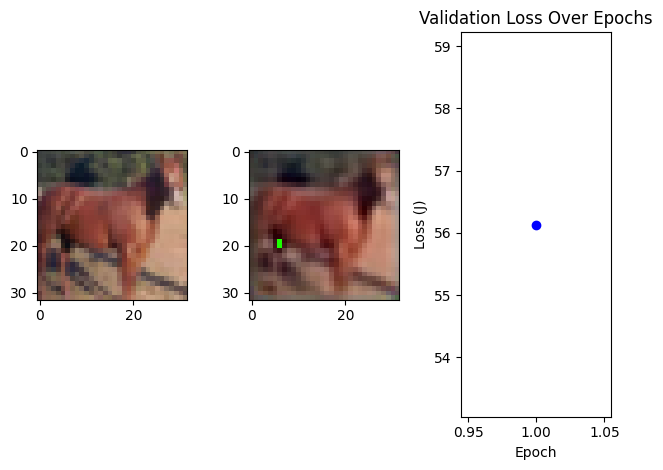

313/313 [==============================] - 122s 364ms/step - loss: 52.2333 - distortion_loss: 0.1005 - rate_loss: 1.9739 - distortion_pass_through_loss: 0.1005 - rate_pass_through_loss: 1.9737 - val_loss: 56.1358 - val_distortion_loss: 0.1086 - val_rate_loss: 1.8224 - val_distortion_pass_through_loss: 0.1087 - val_rate_pass_through_loss: 1.8226
Model: "analysis_transform"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 32, 32, 20)        1520      
                                                                 
 conv_2 (Conv2D)             (None, 32, 32, 50)        25050     
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
Total params: 26570 (103.79 KB)
Trainable params: 26570 (103.79 KB)
Non-trainable params: 0 (0.00

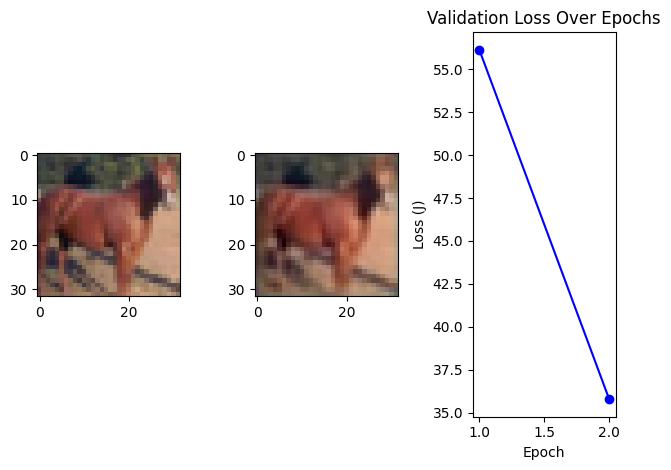

313/313 [==============================] - 98s 313ms/step - loss: 29.5522 - distortion_loss: 0.0557 - rate_loss: 1.7248 - distortion_pass_through_loss: 0.0556 - rate_pass_through_loss: 1.7246 - val_loss: 35.7730 - val_distortion_loss: 0.0684 - val_rate_loss: 1.5814 - val_distortion_pass_through_loss: 0.0684 - val_rate_pass_through_loss: 1.5818
Epoch: 2
Using weights previously generated
  5/313 [..............................] - ETA: 15s - loss: 25.9978 - distortion_loss: 0.0488 - rate_loss: 1.6194 - distortion_pass_through_loss: 0.0488 - rate_pass_through_loss: 1.6194

313/313 [==============================] - ETA: 0s - loss: 24.2677 - distortion_loss: 0.0455 - rate_loss: 1.5381 - distortion_pass_through_loss: 0.0455 - rate_pass_through_loss: 1.5380
Saved weights.
R=132.369140625 D=7.856750965118408 D+R=140.22589111328125 LATENT_SIZE=51200


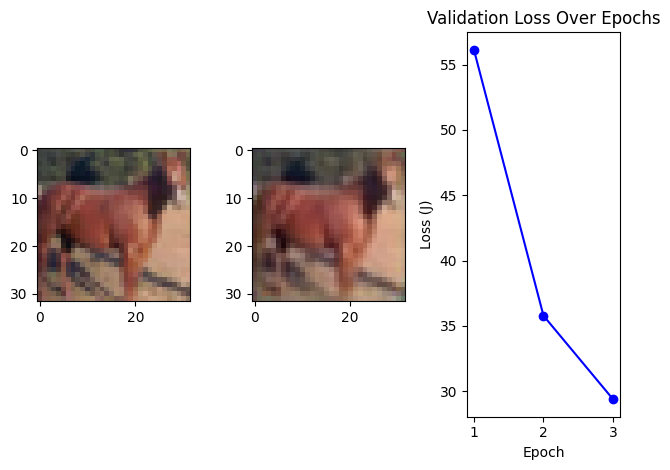

313/313 [==============================] - 97s 312ms/step - loss: 24.2677 - distortion_loss: 0.0455 - rate_loss: 1.5381 - distortion_pass_through_loss: 0.0455 - rate_pass_through_loss: 1.5380 - val_loss: 29.3754 - val_distortion_loss: 0.0559 - val_rate_loss: 1.4059 - val_distortion_pass_through_loss: 0.0559 - val_rate_pass_through_loss: 1.4064
Epoch: 3
Using weights previously generated
  6/313 [..............................] - ETA: 14s - loss: 22.3695 - distortion_loss: 0.0418 - rate_loss: 1.4603 - distortion_pass_through_loss: 0.0418 - rate_pass_through_loss: 1.4603

313/313 [==============================] - ETA: 0s - loss: 21.2482 - distortion_loss: 0.0397 - rate_loss: 1.4130 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 1.4129
Saved weights.
R=135.8486328125 D=8.07314395904541 D+R=143.92178344726562 LATENT_SIZE=51200


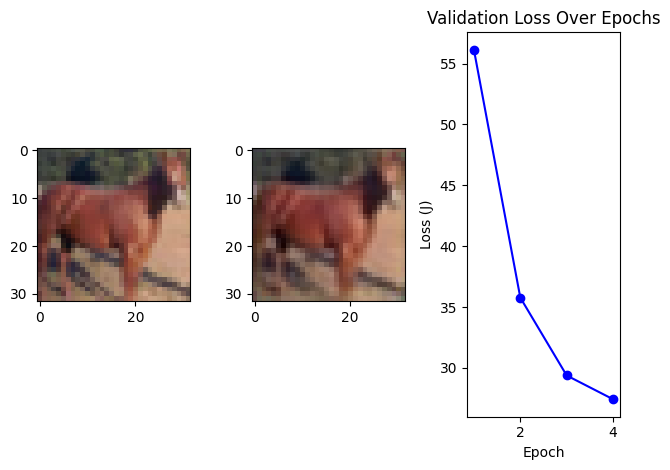

313/313 [==============================] - 98s 313ms/step - loss: 21.2482 - distortion_loss: 0.0397 - rate_loss: 1.4130 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 1.4129 - val_loss: 27.4212 - val_distortion_loss: 0.0523 - val_rate_loss: 1.2706 - val_distortion_pass_through_loss: 0.0523 - val_rate_pass_through_loss: 1.2711
Epoch: 4
Using weights previously generated
  6/313 [..............................] - ETA: 14s - loss: 19.9885 - distortion_loss: 0.0373 - rate_loss: 1.3587 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 1.3587

312/313 [============================>.] - ETA: 0s - loss: 19.0781 - distortion_loss: 0.0355 - rate_loss: 1.3351 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 1.3351
Saved weights.
R=136.9140625 D=7.0335307121276855 D+R=143.9475860595703 LATENT_SIZE=51200


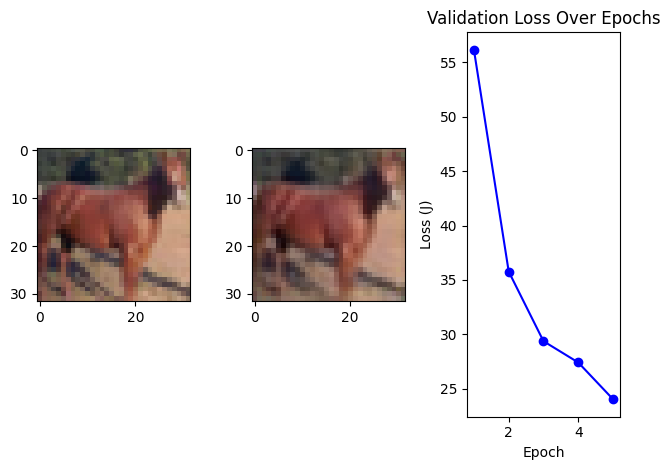

313/313 [==============================] - 99s 317ms/step - loss: 19.0772 - distortion_loss: 0.0355 - rate_loss: 1.3351 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 1.3351 - val_loss: 24.0451 - val_distortion_loss: 0.0457 - val_rate_loss: 1.1894 - val_distortion_pass_through_loss: 0.0457 - val_rate_pass_through_loss: 1.1899
Epoch: 5
Using weights previously generated
  5/313 [..............................] - ETA: 16s - loss: 19.3378 - distortion_loss: 0.0361 - rate_loss: 1.3014 - distortion_pass_through_loss: 0.0361 - rate_pass_through_loss: 1.3014

312/313 [============================>.] - ETA: 0s - loss: 17.5746 - distortion_loss: 0.0326 - rate_loss: 1.2804 - distortion_pass_through_loss: 0.0326 - rate_pass_through_loss: 1.2804
Saved weights.
R=137.8779296875 D=6.996110916137695 D+R=144.87403869628906 LATENT_SIZE=51200


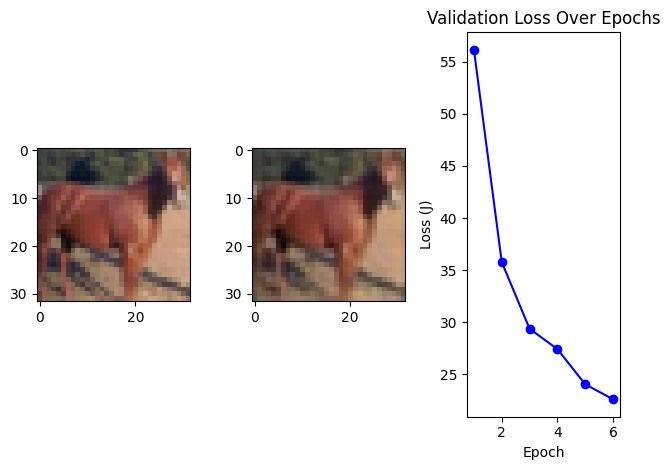

313/313 [==============================] - 98s 314ms/step - loss: 17.5748 - distortion_loss: 0.0326 - rate_loss: 1.2803 - distortion_pass_through_loss: 0.0326 - rate_pass_through_loss: 1.2803 - val_loss: 22.6127 - val_distortion_loss: 0.0430 - val_rate_loss: 1.1216 - val_distortion_pass_through_loss: 0.0430 - val_rate_pass_through_loss: 1.1221
Epoch: 6
Using weights previously generated
  6/313 [..............................] - ETA: 17s - loss: 17.0561 - distortion_loss: 0.0316 - rate_loss: 1.2504 - distortion_pass_through_loss: 0.0316 - rate_pass_through_loss: 1.2504

312/313 [============================>.] - ETA: 0s - loss: 16.3817 - distortion_loss: 0.0303 - rate_loss: 1.2482 - distortion_pass_through_loss: 0.0303 - rate_pass_through_loss: 1.2482
Saved weights.
R=138.384765625 D=5.666963577270508 D+R=144.05172729492188 LATENT_SIZE=51200


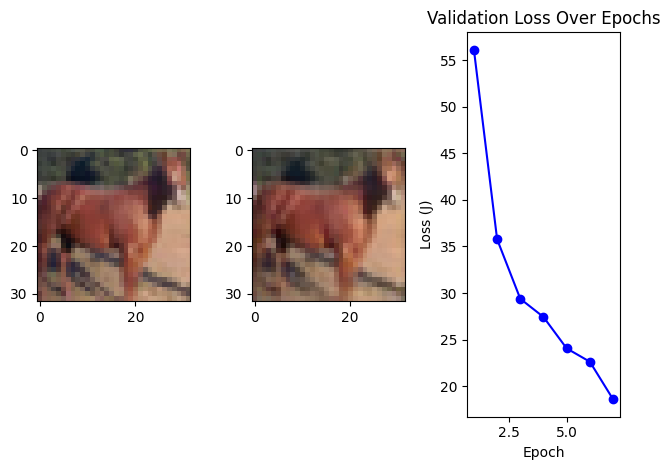

313/313 [==============================] - 100s 319ms/step - loss: 16.3815 - distortion_loss: 0.0303 - rate_loss: 1.2481 - distortion_pass_through_loss: 0.0303 - rate_pass_through_loss: 1.2481 - val_loss: 18.5815 - val_distortion_loss: 0.0350 - val_rate_loss: 1.0796 - val_distortion_pass_through_loss: 0.0350 - val_rate_pass_through_loss: 1.0800
Epoch: 7
Using weights previously generated
  6/313 [..............................] - ETA: 15s - loss: 15.2673 - distortion_loss: 0.0281 - rate_loss: 1.2284 - distortion_pass_through_loss: 0.0281 - rate_pass_through_loss: 1.2284

312/313 [============================>.] - ETA: 0s - loss: 15.5219 - distortion_loss: 0.0286 - rate_loss: 1.2318 - distortion_pass_through_loss: 0.0286 - rate_pass_through_loss: 1.2318
Saved weights.
R=139.0771484375 D=5.788315773010254 D+R=144.86546325683594 LATENT_SIZE=51200


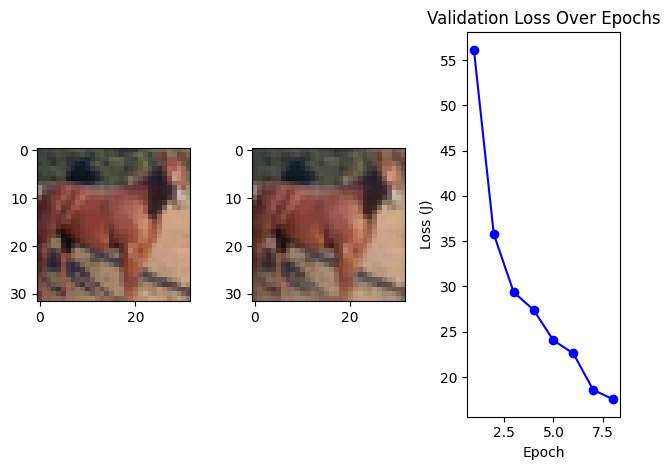

313/313 [==============================] - 100s 319ms/step - loss: 15.5238 - distortion_loss: 0.0286 - rate_loss: 1.2318 - distortion_pass_through_loss: 0.0286 - rate_pass_through_loss: 1.2318 - val_loss: 17.5490 - val_distortion_loss: 0.0330 - val_rate_loss: 1.0645 - val_distortion_pass_through_loss: 0.0330 - val_rate_pass_through_loss: 1.0649
Epoch: 8
Using weights previously generated
  5/313 [..............................] - ETA: 14s - loss: 14.6683 - distortion_loss: 0.0269 - rate_loss: 1.2205 - distortion_pass_through_loss: 0.0269 - rate_pass_through_loss: 1.2205

312/313 [============================>.] - ETA: 0s - loss: 14.8387 - distortion_loss: 0.0272 - rate_loss: 1.2258 - distortion_pass_through_loss: 0.0272 - rate_pass_through_loss: 1.2258
Saved weights.
R=139.8388671875 D=5.419069290161133 D+R=145.2579345703125 LATENT_SIZE=51200


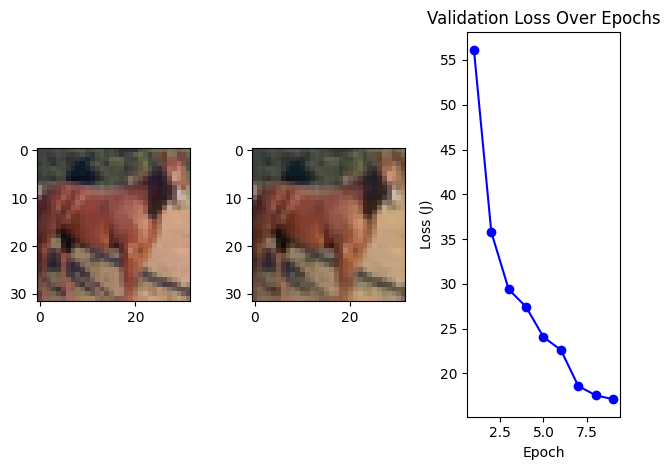

313/313 [==============================] - 100s 320ms/step - loss: 14.8367 - distortion_loss: 0.0272 - rate_loss: 1.2258 - distortion_pass_through_loss: 0.0272 - rate_pass_through_loss: 1.2258 - val_loss: 17.1046 - val_distortion_loss: 0.0321 - val_rate_loss: 1.0692 - val_distortion_pass_through_loss: 0.0321 - val_rate_pass_through_loss: 1.0695
Epoch: 9
Using weights previously generated
  5/313 [..............................] - ETA: 16s - loss: 14.9082 - distortion_loss: 0.0274 - rate_loss: 1.2305 - distortion_pass_through_loss: 0.0274 - rate_pass_through_loss: 1.2305

313/313 [==============================] - ETA: 0s - loss: 14.2790 - distortion_loss: 0.0261 - rate_loss: 1.2245 - distortion_pass_through_loss: 0.0261 - rate_pass_through_loss: 1.2244
Saved weights.
R=140.7021484375 D=5.222533226013184 D+R=145.9246826171875 LATENT_SIZE=51200


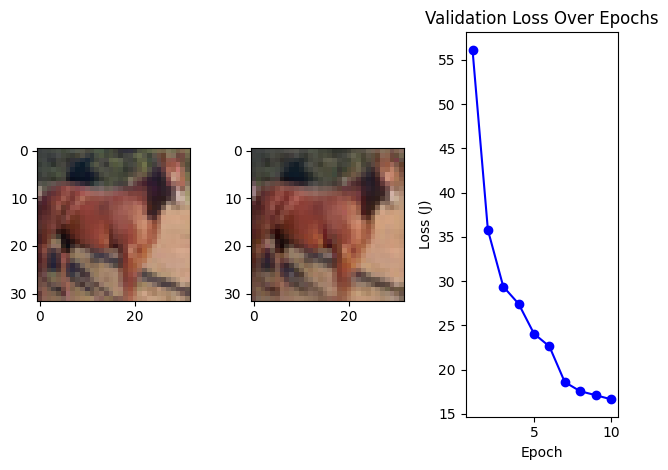

313/313 [==============================] - 99s 318ms/step - loss: 14.2790 - distortion_loss: 0.0261 - rate_loss: 1.2245 - distortion_pass_through_loss: 0.0261 - rate_pass_through_loss: 1.2244 - val_loss: 16.6401 - val_distortion_loss: 0.0312 - val_rate_loss: 1.0476 - val_distortion_pass_through_loss: 0.0312 - val_rate_pass_through_loss: 1.0480
Epoch: 10
Using weights previously generated
  5/313 [..............................] - ETA: 16s - loss: 13.5464 - distortion_loss: 0.0247 - rate_loss: 1.2133 - distortion_pass_through_loss: 0.0247 - rate_pass_through_loss: 1.2133

312/313 [============================>.] - ETA: 0s - loss: 13.7709 - distortion_loss: 0.0251 - rate_loss: 1.2221 - distortion_pass_through_loss: 0.0251 - rate_pass_through_loss: 1.2221
Saved weights.
R=141.14453125 D=5.647729873657227 D+R=146.79226684570312 LATENT_SIZE=51200


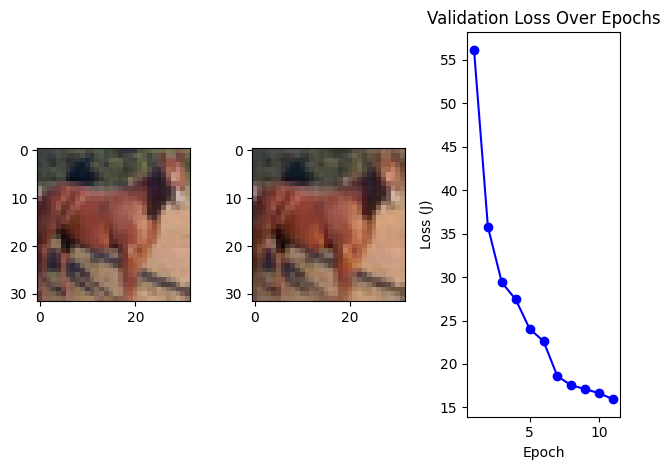

313/313 [==============================] - 97s 312ms/step - loss: 13.7711 - distortion_loss: 0.0251 - rate_loss: 1.2221 - distortion_pass_through_loss: 0.0251 - rate_pass_through_loss: 1.2221 - val_loss: 15.9441 - val_distortion_loss: 0.0298 - val_rate_loss: 1.0518 - val_distortion_pass_through_loss: 0.0298 - val_rate_pass_through_loss: 1.0521
Epoch: 11
Using weights previously generated
313/313 [==============================] - ETA: 0s - loss: 13.3587 - distortion_loss: 0.0243 - rate_loss: 1.2171 - distortion_pass_through_loss: 0.0243 - rate_pass_through_loss: 1.2171
Saved weights.


KeyboardInterrupt: ignored

In [18]:
callbacks_list = [MyCallback()]
trainer = make_compression_trainer(lmbda=LAMBDA)
print("Epoch:", 0)
trainer.fit(
  training_dataset.map(add_rd_targets).batch(128).prefetch(8),
  epochs=1,
  validation_data=validation_dataset.map(add_rd_targets).batch(128).cache(),
  validation_freq=1,
    verbose=1,
  callbacks=callbacks_list
)
trainer.analysis_transform.summary()
trainer.synthesis_transform.summary()
for i in range(1, EPOCHS):
  print("Epoch:", i)
  trainer.fit(
    training_dataset.map(add_rd_targets).batch(128).prefetch(8),
    epochs=1,
    validation_data=validation_dataset.map(add_rd_targets).batch(128).cache(),
    validation_freq=1,
    verbose=1,
    callbacks=callbacks_list
  )
#trainer = train_model(lmbda=LAMBDA)

In [19]:
class Compressor(tf.keras.Model):
  """Compresses images to strings."""

  def __init__(self, analysis_transform, entropy_model):
    super().__init__()
    self.analysis_transform = analysis_transform
    self.entropy_model = entropy_model

  def call(self, x):
    # Ensure inputs are floats in the range (0, 1).
    x = tf.cast(x, self.compute_dtype) / 255.
    y = self.analysis_transform(x)
    # Also return the exact information content of each digit.
    _, bits = self.entropy_model(y, training=False)
    return self.entropy_model.compress(y), bits

class Decompressor(tf.keras.Model):
  """Decompresses images from strings."""

  def __init__(self, entropy_model, synthesis_transform):
    super().__init__()
    self.entropy_model = entropy_model
    self.synthesis_transform = synthesis_transform

  def call(self, string):
    y_hat = self.entropy_model.decompress(string, ())
    x_hat = self.synthesis_transform(y_hat)
    # Scale and cast back to 8-bit integer.
    return tf.saturate_cast(tf.round(x_hat * 255.), tf.uint8)

def make_codec(trainer, **kwargs):
  # The entropy model must be created with `compression=True` and the same
  # instance must be shared between compressor and decompressor.
  entropy_model = tfc.ContinuousBatchedEntropyModel(
      trainer.prior, coding_rank=1, compression=True, **kwargs)
  compressor = Compressor(trainer.analysis_transform, entropy_model)
  decompressor = Decompressor(entropy_model, trainer.synthesis_transform)
  return compressor, decompressor

compressor, decompressor = make_codec(trainer)

In [20]:
def display_images(originals, strings, entropies, reconstructions):
  """Visualizes 16 digits together with their reconstructions."""
  fig, axes = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(12.5, 5))
  axes = axes.ravel()
  for i in range(len(axes)):
    image = tf.concat([
        tf.squeeze(originals[i]),
        tf.zeros((32, 32, 3), tf.uint8),
        tf.squeeze(reconstructions[i]),
    ], 1)
    axes[i].imshow(image)
    axes[i].text(
        #.5, .5, f"→ 0x{strings[i].numpy().hex()} →\n{entropies[i]:0.2f} bits",
        .5, .5, f"{entropies[i]:0.2f} bits",
        ha="center", va="top", color="white", fontsize="small",
        transform=axes[i].transAxes)
    axes[i].axis("off")
  plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)

String representation of first compressed image (in hexadecimal): 0xf2d2e5152aad9fd4cfe8d51b9eb341278b8db911cdaed5b64346616f6ee40b9b352ad5aa40b4fd70b1966cfb47213d1ae0a00d99b5201b4ab83a95d3bfd99bfc80a15c0f83fa7e1eefe172ddb8b7524498511a0200a5b5a390cd16d8b03018a8747ad29c90381e535508c9850f4ca5669505cc2b10fc58068b22ab0f9f3edff592a28fbeb9ad93abd6d697467fd2cb1b95bde6fe247637df115683d84d0e5526d36cdb5ec4cf0ba2de1c9426f27d139ff5910a87310c28321e26b62a594209cffc06c9889bdb557630925bcbb10bb24dab26b00b072e5037ebee9851ef6d042bc0d5445e9d243ca7dc7ba7d2cf9e8fd834b26de6e14fd88a3a00328235eb8e0af3c915dd3f76ae282eca1289eace29449b1663cdfdff1a9c5d8d81df05b984f328e83334cca33ce4ea40dccaf87780d79bbd411e02bed162272e86233a80b6aa3396d86e4f068142c5be196dd1856e42a1a637c870cf25bfbcfb5d00e56421bdea83b6f8c70ba3d55d9211910e3f1604e9835993e409da4c7b22e03ba0958b27d80349741bf1d83e47a148b61c727a6858acf53fba51c4264111ce6ff0ae4f5bd718632c865fcb047452d9b90630083fab915a058c410a667c970803dc9a8d12a61f365050996066de0b6b4909f26373aaf3

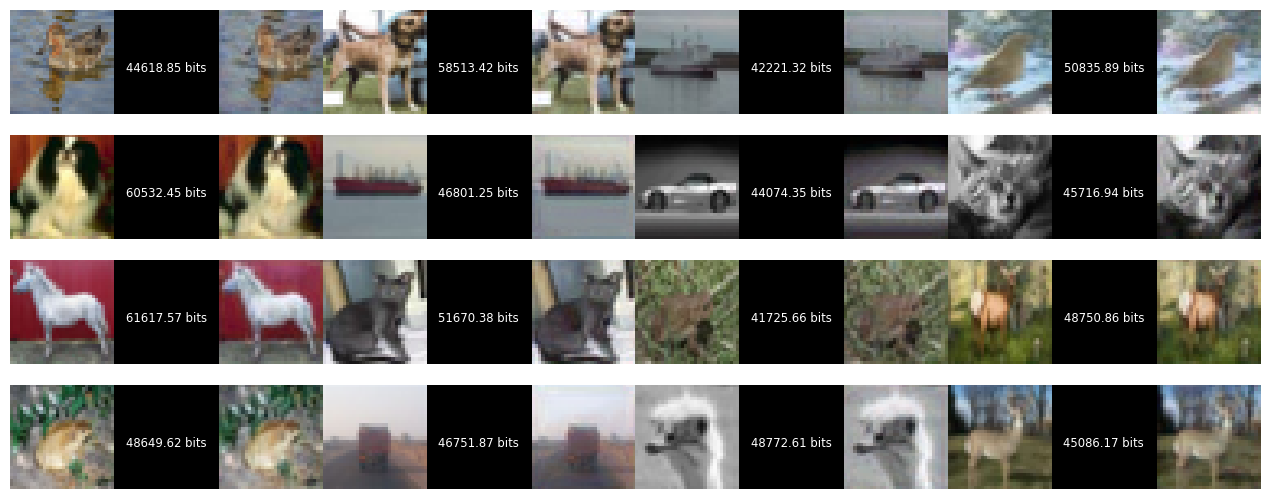

In [21]:
(originals, _), = validation_dataset.batch(16).skip(3).take(1)
strings, entropies = compressor(originals)

print(f"String representation of first compressed image (in hexadecimal): 0x{strings[0].numpy().hex()}")
print(f"Number of bits actually needed to represent it: {entropies[0]:0.2f}")

reconstructions = decompressor(strings)
display_images(originals, strings, entropies, reconstructions)

In [ ]:
# Compare with JPEG

(originals, _), = validation_dataset.batch(16).skip(3).take(1)

reconstructions = []
entropies = []
for count, i in enumerate(originals):
  j = tf.image.encode_jpeg(i)
  k = tf.image.decode_jpeg(j)
  reconstructions.append(k)
  file_path = f"{count:02d}.jpg"
  with open(file_path, "wb") as file:
    file.write(j.numpy())
  length_j = tf.strings.length(j)*8
  entropies.append(length_j)

display_images(originals, strings, entropies, reconstructions)

In [ ]:
!ls -l